In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
output_dir = osp.join(RESULTS_DATA_DIR, 'training-classifier', 'run1')
output_dir

'/lab/data/results/training-classifier/run1'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

# inducing cytokine: {'marker_list': 'doub_01', 'use_secondary': True, 'use_swaps': True, 'use_positions': True, 'wrd_embedding_type': 'w2v_trained', 
# 'model_size': 'XXXXL', 'weight_decay': 0.0, 'learning_rate': 0.01, 'dropout': 0.75, 'cell_type': 'LSTM', 'bidirectional': False, 
# 'score': 0.521739130434782, 'task': 'inducing_cytokine', 'iteration': 0}
space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .00001, .0001, .001], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [5]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 576


In [6]:
from skopt import forest_minimize, dummy_minimize
client_args = dict(cli=dict(batch_size=512), train=dict(log_iter_interval=150, log_epoch_interval=5))
optimizers = {
    task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=dummy_minimize, client_args=client_args) 
    for task in tasks
}

### Create Splits for Tasks

In [7]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN])).all()
len(cands)

120778

In [8]:
# DB splits -> modeling splits 
TARGET_MAP = {'train': 'train', 'val': 'val', 'test': 'test'}
df_cand = pd.DataFrame([
    dict(id=c.id, task=c.type, split=c.split, label=features.get_label(c, strict=True))
    for c in cands
])
df_cand['split'] = df_cand['split'].map(SPLIT_MAP).map(TARGET_MAP)
df_cand.groupby(['task', 'split']).size()

task                           split
inducing_cytokine              test       100
                               train    48656
                               val         97
inducing_transcription_factor  test       100
                               train    22983
                               val        117
secreted_cytokine              test       100
                               train    48527
                               val         98
dtype: int64

In [9]:
for task, g in df_cand.groupby('task'):
    _rs = lambda: np.random.RandomState(TCRE_SEED)
    splits = g.groupby('split')['id'].unique().apply(lambda v: _rs().choice(v, size=min(10000, len(v)), replace=False))
    print(f'Splits for task "{task}":')
    print(splits.apply(len))
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Splits for task "inducing_cytokine":
split
test       100
train    10000
val         97
Name: id, dtype: int64
Splits written to /lab/data/results/training-classifier/run1/inducing_cytokine/splits/splits.json
Splits for task "inducing_transcription_factor":
split
test       100
train    10000
val        117
Name: id, dtype: int64
Splits written to /lab/data/results/training-classifier/run1/inducing_transcription_factor/splits/splits.json
Splits for task "secreted_cytokine":
split
test       100
train    10000
val         98
Name: id, dtype: int64
Splits written to /lab/data/results/training-classifier/run1/secreted_cytokine/splits/splits.json


### Run Search

In [10]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/training-classifier/run1/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/training-classifier/run1/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --log-iter-interval=150 --log-epoch-interval=5 --marker-list=doub_01 --use-secondary=True --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=XXXL --weight-decay=0.001 --learning-rate=0.01 --dropout=0.25 --cell-type=LSTM --bidirectional=False > /lab/data/results/training-classifier/run1/inducing_cytokine/log/log.txt 2>&1


In [11]:
# For 3 tasks at about about 360s per iteration, show common time estimations:
time_per_iter_sec = 360
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 3.0 (hrs)
Iterations = 100 --> Time = 30.0 (hrs)
Iterations = 250 --> Time = 75.0 (hrs)
Iterations = 500 --> Time = 150.0 (hrs)
Iterations = 1000 --> Time = 300.0 (hrs)


In [ ]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    res, scores, callbacks = optimizer.run(n_iterations=10, progress_interval=1, checkpoint_interval=1)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-07-09 20:31:00,625:INFO:root: Running optimization for task inducing_cytokine
2019-07-09 20:31:00,626:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 10
2019-07-09 20:35:19,899:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run1/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-09 20:35:19,916:INFO:tcre.exec.v1.optim: Completed iteration 1 of 10 (score = -0.559999999999999)
2019-07-09 20:40:29,950:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run1/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-09 20:40:29,971:INFO:tcre.exec.v1.optim: Completed iteration 2 of 10 (score = -0.461538461538461)
2019-07-09 20:44:35,027:INFO:tcre.exec.v1.optim: Saving checkpoint to /lab/data/results/training-classifier/run1/inducing_cytokine/checkpoints/checkpoint.pkl
2019-07-09 20:44:35,049:INFO:tcre.exec.v1.optim: Completed iteration 3 of 10 (score = -0.22222222222222202)
2019-07-09 20:48:06,941:

In [51]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [52]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count      3.000000
mean     357.958764
std      127.910002
min      251.829914
25%      286.947712
50%      322.065509
75%      411.023190
max      499.980870
dtype: float64

## Analysis

In [54]:
output_dir

'/lab/data/results/training-classifier/run1'

In [55]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [71]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [72]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [73]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXXL,0.000,0.01,0.75,LSTM,False,0.521739,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXXL,0.001,0.05,0.25,LSTM,False,0.200000,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.001,0.01,0.00,LSTM,False,0.333333,inducing_cytokine,2


In [80]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  use_positions  \
task                                                                       
inducing_cytokine 1     doub_01          False       True           True   
                  2     doub_01          False       True           True   
                  0     doub_01           True       True           True   

                    wrd_embedding_type model_size  weight_decay  \
task                                                              
inducing_cytokine 1        w2v_trained      XXXXL         0.001   
                  2         w2v_frozen      XXXXL         0.001   
                  0        w2v_trained      XXXXL         0.000   

                     learning_rate  dropout cell_type  bidirectional  \
task                                                                   
inducing_cytokine 1           0.05     0.25      LSTM          False   
                  2           0.01     0.00      LSTM          False   
                  0           0.01     0.75      LSTM          False   

                        score               task  iteration  
task                                                         
inducing_cytokine 1  0.200000  inducing_cytokine          1  
                  2  0.333333  inducing_cytokine          2  
                  0  0.521739  inducing_cytokine          0

### Parameter Regression

In [81]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [82]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.

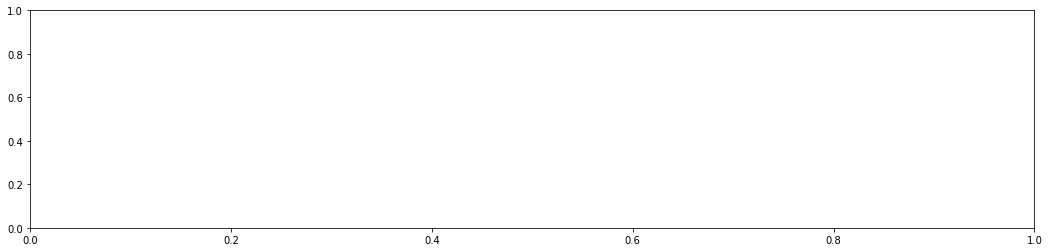

In [83]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [37]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.618068,RidgeCV,0.306541,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.618068,RidgeCV,0.306541,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.0,0.031066,0.009523
3,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.25,-0.023913,-0.007330
4,inducing_cytokine,0.618068,RidgeCV,0.306541,dropout:0.5,0.006178,0.001894


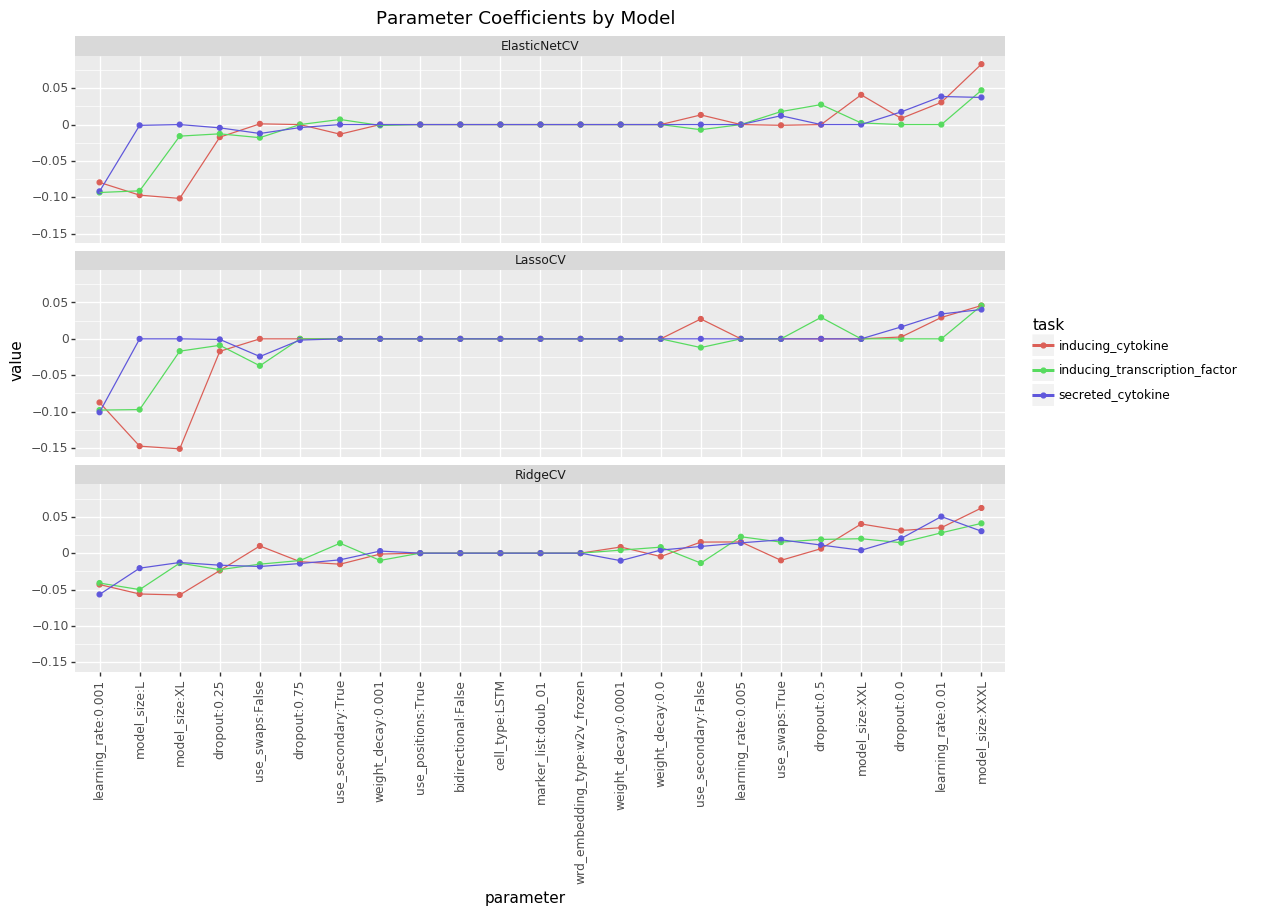

<ggplot: (-9223363302176086205)>

In [38]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [92]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,test,accuracy,0.800000,inducing_cytokine
1,0,test,ct,100.000000,inducing_cytokine
2,0,test,f1,0.333333,inducing_cytokine
3,0,test,loss,0.575303,inducing_cytokine
4,0,test,lr,0.002500,inducing_cytokine


In [94]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > .5, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                  count       percent      
label                                    0     1       0     1
task                          split                           
inducing_cytokine             test      86    14    0.86  0.14
                              train  41513  7143    0.85  0.15
                              val       84    13    0.87  0.13
inducing_transcription_factor test      82    18    0.82  0.18
                              train  18062  4921    0.79  0.21
                              val       95    22    0.81  0.19
secreted_cytokine             test      80    20    0.80  0.20
                              train  41904  6623    0.86  0.14
                              val       79    19    0.81  0.19

In [101]:
# Scores at best validation F1 iteration
def get_scores_table(metrics):
    df_bal = (
        df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True)
        .unstack().round(2)[1].unstack([-2, -1])
    )
    return (
        df_score
        .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
        .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)])[metrics])
        .round(2)
        .pipe(lambda df: pd.concat([df, df_bal], axis=1, sort=True))
        .style.background_gradient(low=.1, high=.3)
    )

In [102]:
get_scores_table(['ct', 'f1', 'accuracy', 'precision', 'recall'])

In [103]:
get_scores_table(['ct', 'f1', 'precision', 'precision@70', 'precision@90'])

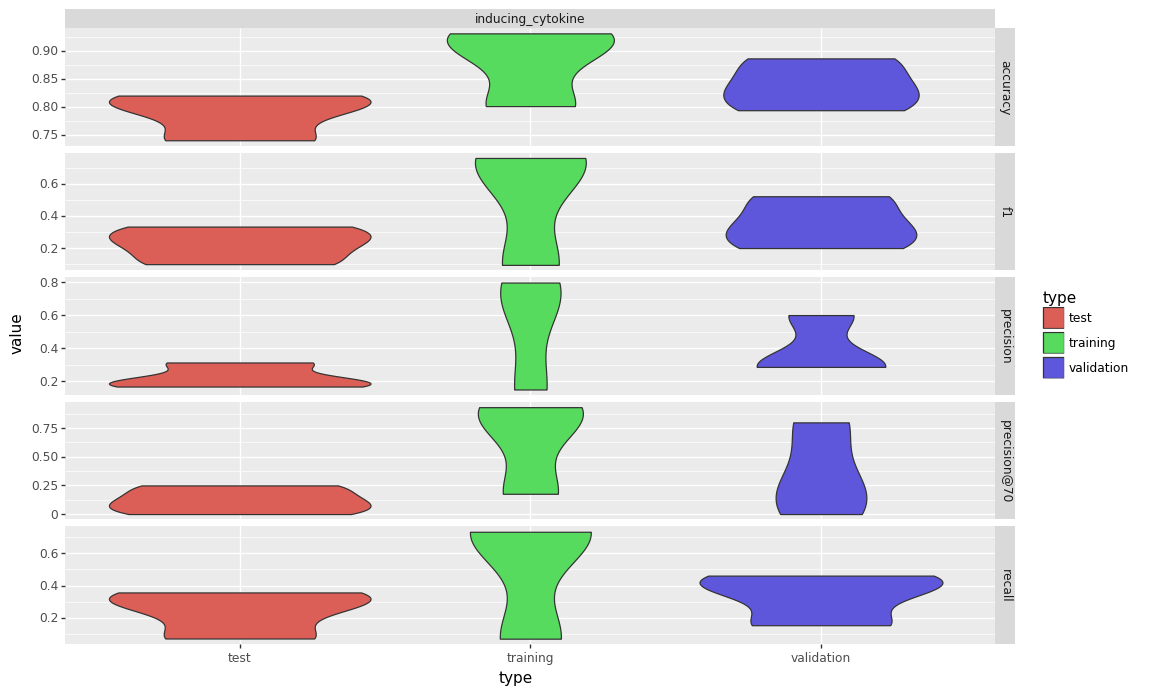

<ggplot: (8783613954070)>

In [105]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'precision@70', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

## Export

Export top model configurations. This is based on the average performance of each parameter as determined by regression.  

Individual max scores are not used to select the top models because the validation set is so small and the search space large enough by comparison that parameter settings that result in poor models on average often end up at the top of the list.

In [61]:
top_config = {}
for k, v in df_coef_lng.groupby('parameter')['weighted_value'].mean().sort_values(ascending=False).items():
    param, val = k.split(':')
    if param not in top_config:
        top_config[param] = val
top_config

{'dropout': '0.5',
 'wrd_embedding_type': 'w2v_trained',
 'use_positions': 'True',
 'use_secondary': 'False',
 'learning_rate': '0.01',
 'cell_type': 'LSTM',
 'model_size': 'XL',
 'use_swaps': 'False',
 'bidirectional': 'True',
 'marker_list': 'mult_01',
 'weight_decay': '0.005'}

In [63]:
# Unless there is a compelling reason to do otherwise, make sure bidirectional 
# option is false to speed up training
top_config['bidirectional'] = False
top_config

{'dropout': '0.5',
 'wrd_embedding_type': 'w2v_trained',
 'use_positions': 'True',
 'use_secondary': 'False',
 'learning_rate': '0.01',
 'cell_type': 'LSTM',
 'model_size': 'XL',
 'use_swaps': 'False',
 'bidirectional': False,
 'marker_list': 'mult_01',
 'weight_decay': '0.005'}

In [64]:
# Use frozen and trainable versions of best config for further training
top_models = pd.DataFrame([
    {**dict(top_config), **dict(wrd_embedding_type=v)}
    for v in ['w2v_frozen', 'w2v_trained']
])
top_models

,bidirectional,cell_type,dropout,learning_rate,marker_list,model_size,use_positions,use_secondary,use_swaps,weight_decay,wrd_embedding_type
0,False,LSTM,0.5,0.01,mult_01,XL,True,False,False,0.005,w2v_frozen
1,False,LSTM,0.5,0.01,mult_01,XL,True,False,False,0.005,w2v_trained


In [65]:
path = osp.join(output_dir, 'top_model_configurations.json')
top_models.to_json(path)
path

'/lab/data/results/gridsearch-dev/run1/top_model_configurations.json'